# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# READING DATA FROM SOURCE

In [2]:
dfCustomers = pd.read_csv("customers.csv", delimiter = ",")
dfCustomers.set_index("CLIENT_ID", inplace = True)

In [3]:
dfCustomers.head()

,ACCOUNT_ID,GENDER,BIRTH_DT,ACTIVE,LOAN,DISTRICT_ID,SET_SPLIT
CLIENT_ID,,,,,,,
1,1,F,19701213,1,0.0,18,TRAIN
2,2,M,19450204,1,1.0,1,TRAIN
4,3,M,19561201,1,0.0,5,TEST
7,5,M,19290125,1,0.0,15,TRAIN
8,6,F,19380221,1,0.0,51,TRAIN


In [4]:
dfTransactions = pd.read_csv("transactions.csv", delimiter = ",")
dfTransactions.set_index("TRANS_ID", inplace = True)

In [5]:
dfTransactions.head()

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
695247,2378.0,1011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
171812,576.0,1011993,900.0,900.0,CREDIT,CREDIT_IN_CASH
207264,704.0,1011993,1000.0,1000.0,CREDIT,CREDIT_IN_CASH
1117247,3818.0,1011993,600.0,600.0,CREDIT,CREDIT_IN_CASH
579373,1972.0,2011993,400.0,400.0,CREDIT,CREDIT_IN_CASH


In [6]:
dfDistricts =  pd.read_csv("districts.csv", delimiter = ",")
dfDistricts.set_index("DISTRICT_ID", inplace = True)

In [7]:
dfDistricts.head()

,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
DISTRICT_ID,,,,,,,,,
1,1204953,1,100.0,12541,0.29,0.43,167,85677,99107
2,88884,5,46.7,8507,1.67,1.85,132,2159,2674
3,75232,5,41.7,8980,1.95,2.21,111,2824,2813
4,149893,6,67.4,9753,4.64,5.05,109,5244,5892
5,95616,6,51.4,9307,3.85,4.43,118,2616,3040


# DATA EXPLORATION

In this section datasets are just explored. There is no manipulation done to any datasets.

## Uniqueness

Checking if ID values of datasets are unique or not.

### dfCustomers

In [8]:
len(dfCustomers.index.unique()) == len(dfCustomers.index)

True

### dfDistricts

In [9]:
len(dfDistricts.index.unique()) == len(dfDistricts.index)

True

### dfTransactions

dfTransactions contain some duplicated TRANS_IDs.

In [10]:
len(dfTransactions.index.unique()) == len(dfTransactions.index)

False

There are 20000 rows which are duplicated.

In [11]:
dfTransactions[dfTransactions.index.duplicated(keep=False)]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
612405,2087.0,29011993,16983.0,17583.0,CREDIT,CREDIT_IN_CASH
612405,2087.0,29011993,16983.0,17583.0,CREDIT,CREDIT_IN_CASH
796773,2714.0,30011993,800.0,800.0,CREDIT,CREDIT_IN_CASH
796773,2714.0,30011993,800.0,800.0,CREDIT,CREDIT_IN_CASH
542217,1844.0,7021993,3242.0,6996.6,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...
3637054,3225.0,31121998,359.2,85171.9,CREDIT,NaN
3553434,696.0,31121998,234.8,56102.8,CREDIT,NaN
3471092,4526.0,31121998,281.5,83037.3,CREDIT,NaN


In [12]:
dfTransactions.loc[3457056]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
3457056,9707.0,31121998,272.0,99872.3,CREDIT,NaN
3457056,9707.0,31121998,272.0,99872.3,CREDIT,NaN


## Data Types

### dfCustomers

"LOAN" field should be either 1 or 0 by description. Usually such fields have integer data types. However, it looks as float64, it s a sign that this field can include some unexpected data.

In [13]:
dfCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450 entries, 1 to 13998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ACCOUNT_ID   4450 non-null   int64  
 1   GENDER       4450 non-null   object 
 2   BIRTH_DT     4450 non-null   int64  
 3   ACTIVE       4450 non-null   int64  
 4   LOAN         4400 non-null   float64
 5   DISTRICT_ID  4450 non-null   int64  
 6   SET_SPLIT    4450 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 407.2+ KB


Confirming that each client has only 1 account id in dfCustomers dataset.

In [14]:
len(dfCustomers.index.unique()) == len(dfCustomers["ACCOUNT_ID"].unique())

True

### dfDistricts

"UNEMP_95" and "CRIME_95" fields look as object data type. By description of field, "UNEMP_95" should represent unemployment ratio which is float, however it looks as object. Similarly, "CRIME_95" field represents number of committed crimes which should be in integer type. However, it also looks as object. These are signs that, the fields of "UNEMP_95" and "CRIME_95" contain some unexpected data.

In [15]:
dfDistricts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_INHAB      77 non-null     int64  
 1   N_CITIES     77 non-null     int64  
 2   URBAN_RATIO  77 non-null     float64
 3   AVG_SALARY   77 non-null     int64  
 4   UNEMP_95     77 non-null     object 
 5   UNEMP_96     77 non-null     float64
 6   N_ENTR       77 non-null     int64  
 7   CRIME_95     77 non-null     object 
 8   CRIME_96     77 non-null     int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 8.1+ KB


### dfTransactions

"ACCOUNT_ID" field's data type should be integer.

In [16]:
dfTransactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1066320 entries, 695247 to 3624981
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ACCOUNT_ID  1061320 non-null  float64
 1   DATE        1066320 non-null  int64  
 2   AMOUNT      1066320 non-null  float64
 3   BALANCE     1066320 non-null  float64
 4   TYPE        1066320 non-null  object 
 5   OPERATION   881436 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 89.2+ MB


## Missing Data

### dfCustomers

Only field 'LOAN' includes NaN values in dfCustomers dataframe.

In [17]:
dfCustomers.columns[dfCustomers.isna().any()].tolist()

['LOAN']

Checking unique fields to be sure if any other missing values except NaN. Unique values are sorted to detect missing values on the boundaries of the sorted array.

In [18]:
np.sort(dfCustomers.index.unique())

array([    1,     2,     4, ..., 13968, 13971, 13998], dtype=int64)

In [19]:
np.sort(dfCustomers["ACCOUNT_ID"].unique())

array([    1,     2,     3, ..., 11359, 11362, 11382], dtype=int64)

In [20]:
np.sort(dfCustomers["GENDER"].unique())

array(['F', 'M'], dtype=object)

In [21]:
np.sort(dfCustomers["BIRTH_DT"].unique())

array([19180107, 19180111, 19180116, ..., 19821005, 19821020, 19821211],
      dtype=int64)

In [23]:
np.sort(dfCustomers["ACTIVE"].unique())

array([1], dtype=int64)

In [24]:
np.sort(dfCustomers["LOAN"].unique())

array([ 0.,  1., nan])

In [25]:
np.sort(dfCustomers["DISTRICT_ID"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77], dtype=int64)

In [26]:
np.sort(dfCustomers["SET_SPLIT"].unique())

array(['TEST', 'TRAIN'], dtype=object)

### dfDistricts

Looks like there is no field that contains NaN value in dfDistricts.

In [27]:
dfDistricts.columns[dfDistricts.isna().any()].tolist()

[]

Checking unique fields to be sure if any other missing values except NaN. Unique values are sorted to detect missing values on the boundaries of the sorted array.

In [28]:
np.sort(dfDistricts.index.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77], dtype=int64)

In [29]:
np.sort(dfDistricts["N_INHAB"].unique())

array([  42821,   45714,   51313,   51428,   53921,   58400,   58796,
         67298,   70646,   70699,   72541,   74062,   75232,   75637,
         75685,   77917,   77963,   78955,   81344,   85852,   86513,
         87419,   88757,   88768,   88884,   92084,   93931,   94725,
         94812,   95616,   95907,  102609,  103347,  105058,  105606,
        106054,  107870,  107911,  108871,  109164,  110643,  112065,
        112709,  114006,  114200,  117897,  118650,  119895,  121947,
        122603,  124605,  125236,  125832,  127369,  128118,  133777,
        138032,  139012,  145688,  148545,  149893,  157042,  159617,
        161227,  161854,  161954,  162580,  170449,  177686,  182027,
        197099,  226122,  228848,  285387,  323870,  387570, 1204953],
      dtype=int64)

In [30]:
np.sort(dfDistricts["N_CITIES"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [31]:
np.sort(dfDistricts["URBAN_RATIO"].unique())

array([ 33.9,  36.5,  36.9,  40.7,  41.3,  41.7,  43.7,  43.8,  46. ,
        46.7,  48. ,  48.3,  48.4,  50.5,  50.9,  51.2,  51.4,  51.5,
        51.9,  52. ,  52.4,  52.7,  53. ,  53.5,  53.8,  55.3,  55.6,
        56.4,  56.9,  57.2,  58. ,  58.4,  59. ,  59.1,  59.2,  59.8,
        60.8,  61.4,  61.7,  61.9,  62.1,  62.3,  62.6,  63.1,  63.4,
        63.6,  64.6,  65.3,  67. ,  67.4,  69.4,  69.7,  70.5,  72.8,
        73.5,  74.7,  74.8,  76.3,  80. ,  80.5,  81. ,  81.8,  84.7,
        85.2,  85.3,  85.5,  85.6,  87.7,  89.9, 100. ])

In [32]:
np.sort(dfDistricts["AVG_SALARY"].unique())

array([ 8110,  8114,  8173,  8187,  8208,  8240,  8254,  8288,  8363,
        8369,  8388,  8390,  8402,  8403,  8427,  8441,  8444,  8507,
        8512,  8541,  8544,  8546,  8547,  8554,  8561,  8594,  8598,
        8620,  8624,  8678,  8705,  8720,  8743,  8746,  8754,  8757,
        8772,  8814,  8819,  8843,  8867,  8899,  8909,  8930,  8965,
        8968,  8980,  8991,  8994,  9045,  9060,  9065,  9104,  9198,
        9272,  9307,  9317,  9425,  9538,  9622,  9624,  9650,  9675,
        9753,  9832,  9893,  9897,  9920, 10045, 10124, 10177, 10446,
       10673, 10787, 11277, 12541], dtype=int64)

"UNEMP_95" field contains value of question mark character '?'.

In [33]:
np.sort(dfDistricts["UNEMP_95"].unique())

array(['0.29', '0.45', '0.56', '0.65', '1.02', '1.10', '1.12', '1.25',
       '1.29', '1.39', '1.42', '1.51', '1.60', '1.62', '1.67', '1.72',
       '1.78', '1.79', '1.88', '1.89', '1.95', '2.26', '2.28', '2.38',
       '2.41', '2.47', '2.51', '2.52', '2.53', '2.64', '2.65', '2.77',
       '2.79', '2.80', '2.82', '2.83', '2.95', '3.13', '3.24', '3.32',
       '3.33', '3.38', '3.39', '3.45', '3.51', '3.52', '3.73', '3.79',
       '3.80', '3.83', '3.85', '4.01', '4.09', '4.46', '4.64', '4.69',
       '4.73', '4.75', '4.76', '4.83', '5.38', '5.74', '5.75', '5.77',
       '5.93', '6.43', '6.49', '6.63', '7.08', '7.34', '?'], dtype=object)

In [34]:
np.sort(dfDistricts["UNEMP_96"].unique())

array([0.43, 0.54, 0.59, 1.21, 1.25, 1.29, 1.44, 1.54, 1.71, 1.81, 1.85,
       1.86, 1.96, 2.01, 2.07, 2.21, 2.26, 2.31, 2.43, 2.44, 2.5 , 2.62,
       2.66, 2.68, 2.87, 2.89, 2.94, 2.97, 3.09, 3.22, 3.26, 3.35, 3.47,
       3.49, 3.56, 3.6 , 3.64, 3.67, 3.74, 3.76, 3.95, 3.97, 3.98, 4.02,
       4.12, 4.2 , 4.28, 4.31, 4.43, 4.48, 4.5 , 4.52, 4.72, 4.79, 4.98,
       5.05, 5.39, 5.44, 5.45, 5.56, 5.57, 5.66, 5.72, 5.74, 5.88, 6.55,
       7.01, 7.07, 7.61, 7.68, 7.75, 8.23, 9.4 ])

In [35]:
np.sort(dfDistricts["N_ENTR"].unique())

array([ 81,  87,  90,  94,  96,  97,  99, 100, 102, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       123, 124, 125, 126, 127, 128, 130, 131, 132, 135, 137, 140, 141,
       145, 149, 154, 155, 167], dtype=int64)

"CRIME_95" field contains value of question mark character '?'.

In [36]:
np.sort(dfDistricts["CRIME_95"].unique())

array(['1003', '1029', '1089', '1328', '1562', '1563', '1580', '1597',
       '1655', '1658', '1660', '1740', '1822', '1845', '1850', '18721',
       '1874', '18782', '1879', '2080', '2112', '2123', '2157', '2159',
       '2166', '2212', '2247', '2299', '2564', '2595', '2616', '2640',
       '2653', '2719', '2824', '2854', '2879', '2985', '2987', '3244',
       '3384', '3460', '3475', '3496', '3659', '3729', '3736', '3804',
       '3810', '4063', '4085', '4147', '4289', '4340', '4355', '4484',
       '4650', '4947', '4980', '5179', '5198', '5244', '5323', '5623',
       '5796', '6041', '6079', '6445', '6604', '6949', '818', '85677',
       '9672', '9878', '999', '?'], dtype=object)

In [37]:
np.sort(dfDistricts["CRIME_96"].unique())

array([  888,  1099,  1117,  1127,  1181,  1358,  1452,  1460,  1525,
        1542,  1668,  1717,  1875,  1879,  1903,  1910,  1913,  2059,
        2103,  2122,  2123,  2134,  2218,  2252,  2305,  2325,  2354,
        2471,  2487,  2618,  2674,  2718,  2799,  2804,  2807,  2813,
        2822,  2906,  3040,  3079,  3120,  3158,  3198,  3529,  3590,
        3620,  3651,  3839,  3868,  3891,  3894,  4166,  4265,  4316,
        4433,  4505,  4595,  4743,  4846,  4859,  4987,  5190,  5273,
        5410,  5471,  5887,  5892,  6132,  6261,  6295,  6872,  9208,
       10108, 18347, 18696, 99107], dtype=int64)

### dfTransactions

"ACCOUNT_ID" and "OPERATION" operation fields contain NaN values.

In [38]:
dfTransactions.columns[dfTransactions.isna().any()].tolist()

['ACCOUNT_ID', 'OPERATION']

In [39]:
np.sort(dfTransactions.index.unique())

array([      1,       5,       6, ..., 3682985, 3682986, 3682987],
      dtype=int64)

"ACCOUNT_ID" field contains NaN values.

In [40]:
np.sort(dfTransactions["ACCOUNT_ID"].unique())

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.1362e+04, 1.1382e+04,
              nan])

"DATE" field doesn't contain NaN value but date format is not in DDMMYYY format for some values.

In [46]:
dfTransactions["DATE"].astype(str).str[4:].unique()

array(['993', '1993', '994', '1994', '995', '1995', '996', '1996', '997',
       '1997', '998', '1998'], dtype=object)

In [47]:
np.sort(dfTransactions["AMOUNT"].unique())

array([0.00e+00, 1.00e-01, 2.00e-01, ..., 8.64e+04, 8.73e+04, 8.74e+04])

In [48]:
np.sort(dfTransactions["BALANCE"].unique())

array([-41125.7, -40938.4, -40817. , ..., 194119.3, 196106.5, 209637. ])

In [49]:
np.sort(dfTransactions["TYPE"].unique())

array(['CREDIT', 'WITHDRAWAL'], dtype=object)

"ACCOUNT_ID" field contains NaN values.

In [50]:
dfTransactions["OPERATION"].unique()

array(['CREDIT_IN_CASH', 'COLLECTION_FROM_OTHER_BANK', nan,
       'WITHDRAWAL_IN_CASH', 'REMITTANCE_TO_OTHER_BANK', 'CC_WITHDRAWAL'],
      dtype=object)

## Data Formats

### dfCustomers

Confirming that each date value includes 8 characters. It is in YYYYMMDD format as it is mentioned description

In [22]:
dfCustomers["BIRTH_DT"].astype(str).str.len().unique()

array([8], dtype=int64)

In [227]:
np.sort(dfCustomers["BIRTH_DT"].unique())

array([19180107, 19180111, 19180116, ..., 19821005, 19821020, 19821211],
      dtype=int64)

### dfTransactions

It is observed that they are not inserted as DDMMYYY but DDMMYYYY format. And when day of month is less than 10, they are inserted only 1 digit not 2 digits.

In [228]:
dfTransactions["DATE"].astype(str).str.len().unique()

array([7, 8], dtype=int64)

In [44]:
 dfTransactions[dfTransactions["DATE"].astype(str).str[:2] == "50"]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
192096,652.0,5011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
232961,793.0,5011993,3401.0,4201.0,CREDIT,COLLECTION_FROM_OTHER_BANK
637742,2177.0,5011993,5123.0,5923.0,CREDIT,COLLECTION_FROM_OTHER_BANK
2908688,9635.0,5011993,400.0,400.0,CREDIT,CREDIT_IN_CASH
224344,764.0,5021993,6238.0,7338.0,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...
3149369,10451.0,5091998,689.0,14496.7,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK
3147256,10445.0,5091998,23910.0,89535.6,CREDIT,CREDIT_IN_CASH
3145327,10439.0,5091998,10134.0,61170.3,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK


# PREPROCESSING

Data preprocessing is applied to the copied datasets.

In [51]:
dfCustomersModel = dfCustomers.copy()
dfTransactionsModel = dfTransactions.copy()
dfDistrictsModel = dfDistricts.copy()

## Remove Duplicated Rows

### TRANS_ID

One of the duplicated rows are kept. Rest of them are dropped.

In [52]:
dfTransactionsModel.drop_duplicates(inplace = True, keep = "first")

Still there are duplicated rows in terms of index but not for other values. The reason of this situation is that at least one of the duplicated rows contains NaN value.

In [53]:
len(dfTransactionsModel.index.unique()) == len(dfTransactionsModel.index)

False

In [54]:
dfDuplicatedTransactions = dfTransactionsModel[dfTransactionsModel.index.duplicated(keep=False)]

In [55]:
dfDuplicatedTransactions.sort_index()

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
22872,75.0,7021998,12550.0,31876.0,CREDIT,CREDIT_IN_CASH
22872,NaN,7021998,12550.0,31876.0,CREDIT,CREDIT_IN_CASH
47881,NaN,13091997,2000.0,72914.5,WITHDRAWAL,WITHDRAWAL_IN_CASH
47881,160.0,13091997,2000.0,72914.5,WITHDRAWAL,WITHDRAWAL_IN_CASH
59550,198.0,5061998,2166.0,26504.1,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK
...,...,...,...,...,...,...
3613793,2523.0,31081994,116.4,27971.4,CREDIT,NaN
3647583,NaN,31081996,311.8,84873.1,CREDIT,NaN
3647583,3558.0,31081996,311.8,84873.1,CREDIT,NaN


We can fill missing values by copying from its duplicated index.

In [56]:
aDuplicatedTransIds = dfDuplicatedTransactions.index.unique()


for iTransId in aDuplicatedTransIds:
    
    for j in range(dfTransactionsModel.shape[1]):
        sColumnName = dfTransactionsModel.columns[j]
        
        aColumnValues = dfTransactionsModel.loc[iTransId, sColumnName]
        
        iNrOfMissingValues = aColumnValues.isna().sum()
        iNrOfDuplicates = len(aColumnValues)
        
        if iNrOfMissingValues > 0 and iNrOfMissingValues < iNrOfDuplicates:
            
            aNonMissingValues = aColumnValues[aColumnValues.notna()]
            iNrOfNonMissingValues = len(aNonMissingValues)
            
            if iNrOfNonMissingValues == 1:
                dfTransactionsModel.loc[iTransId, sColumnName] = aNonMissingValues
            
        
        


After filling missing values from it's duplicated row, dropping duplicates is applied once again. It is observed that, there is no more duplicated rows.

In [57]:
dfTransactionsModel.drop_duplicates(inplace = True, keep = "first")

In [58]:
len(dfTransactionsModel.index.unique()) == len(dfTransactionsModel.index)

True

## Converting Date Formats

### BIRTH_DT

In [59]:
dfCustomersModel["BIRTH_DT"] = pd.to_datetime(dfCustomersModel["BIRTH_DT"], format="%Y%m%d")

In [60]:
np.sort(dfCustomersModel["BIRTH_DT"].unique())

array(['1918-01-07T00:00:00.000000000', '1918-01-11T00:00:00.000000000',
       '1918-01-16T00:00:00.000000000', ...,
       '1982-10-05T00:00:00.000000000', '1982-10-20T00:00:00.000000000',
       '1982-12-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [61]:
dfCustomersModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450 entries, 1 to 13998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ACCOUNT_ID   4450 non-null   int64         
 1   GENDER       4450 non-null   object        
 2   BIRTH_DT     4450 non-null   datetime64[ns]
 3   ACTIVE       4450 non-null   int64         
 4   LOAN         4400 non-null   float64       
 5   DISTRICT_ID  4450 non-null   int64         
 6   SET_SPLIT    4450 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 407.2+ KB


### DATE

"DATE" field should be in DDMMYYY based on description however, it is in DMMYYYY format. For the days that are less than 10, day of month is represented just 1 digit. 

 "0" character is added at the beginning of the values where day of month is represented with single value. 

In [62]:
dfTransactionsModel["DATE"] = dfTransactionsModel["DATE"].astype(str)
adfTransactionsWith7DigitsDates = dfTransactionsModel[dfTransactionsModel["DATE"].str.len() == 7]
dfTransactionsModel.loc[adfTransactionsWith7DigitsDates.index, "DATE"] = "0" + dfTransactionsModel.loc[adfTransactionsWith7DigitsDates.index, "DATE"]

In [63]:
dfTransactionsModel["DATE"] = pd.to_datetime(dfTransactionsModel["DATE"], format="%d%m%Y")

In [64]:
np.sort(dfTransactionsModel["DATE"].unique())

array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ...,
       '1998-12-29T00:00:00.000000000', '1998-12-30T00:00:00.000000000',
       '1998-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [65]:
dfTransactionsModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056319 entries, 695247 to 3624981
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   ACCOUNT_ID  1051404 non-null  float64       
 1   DATE        1056319 non-null  datetime64[ns]
 2   AMOUNT      1056319 non-null  float64       
 3   BALANCE     1056319 non-null  float64       
 4   TYPE        1056319 non-null  object        
 5   OPERATION   873206 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 88.7+ MB


## Missing Data Handling

### LOAN

There are 50 customers which have NaN value on their "LOAN" field. Empty "LOAN" data can't be used for training or testing purposes. That's why, the customers which don't have "LOAN" information are dropped from dfCustomersModel and dfTransactionsModel datasets.

In [66]:
dfCustomersMissingLoan = dfCustomers[dfCustomers["LOAN"].isna()]

dfTransactionsMissingLoan = dfTransactions.reset_index().merge(
    dfCustomersMissingLoan, 
    how = "inner", 
    on = "ACCOUNT_ID").set_index("TRANS_ID")


dfTransactionsModel.drop(dfTransactionsMissingLoan.index, inplace = True)
dfCustomersModel.drop(dfCustomersMissingLoan.index, inplace = True)

In [67]:
dfCustomersModel["LOAN"] = dfCustomersModel["LOAN"].astype(np.int64)

### UNEMP_95 & CRIME_95

There is 1 district (DISTRICT_ID=69) whose "UNEMP_95" and "CRIME_95" fields are empty.

In [68]:
dfDistricts[dfDistricts["UNEMP_95"] == "?"]

,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
DISTRICT_ID,,,,,,,,,
69,42821,3,48.4,8173,?,7.01,124,?,1358


In [69]:
dfDistricts[dfDistricts["CRIME_95"] == "?"]

,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
DISTRICT_ID,,,,,,,,,
69,42821,3,48.4,8173,?,7.01,124,?,1358


A predictive model is used to produce a value instead of question mark. As it is mentioned above, "UNEMP_95" and "CRIME_95" are in object format not in float format. The reason of this situation was because of question mark character on DISTRIC_ID=96. 
This row is dropped for temporary purpose from dataset to convert "UNEMP_95" and "CRIME_95" to float data type so that we can perform some numerical analysis. After missing values are predicted, DISTRICT_ID = 69 will be appended back to dfDistrictsModel.

In [70]:
dfMissingRows = dfDistrictsModel[(dfDistrictsModel["UNEMP_95"] == "?") | (dfDistrictsModel["CRIME_95"] == "?")]

dfDistrictsModel.drop(dfMissingRows.index, inplace = True)

dfDistrictsModel["UNEMP_95"] = pd.to_numeric(dfDistrictsModel["UNEMP_95"])
dfDistrictsModel["CRIME_95"] = pd.to_numeric(dfDistrictsModel["CRIME_95"])

dfDistrictsModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 1 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_INHAB      76 non-null     int64  
 1   N_CITIES     76 non-null     int64  
 2   URBAN_RATIO  76 non-null     float64
 3   AVG_SALARY   76 non-null     int64  
 4   UNEMP_95     76 non-null     float64
 5   UNEMP_96     76 non-null     float64
 6   N_ENTR       76 non-null     int64  
 7   CRIME_95     76 non-null     int64  
 8   CRIME_96     76 non-null     int64  
dtypes: float64(3), int64(6)
memory usage: 5.9 KB


A heatmap is created to understand if there are any strong relationships between features.

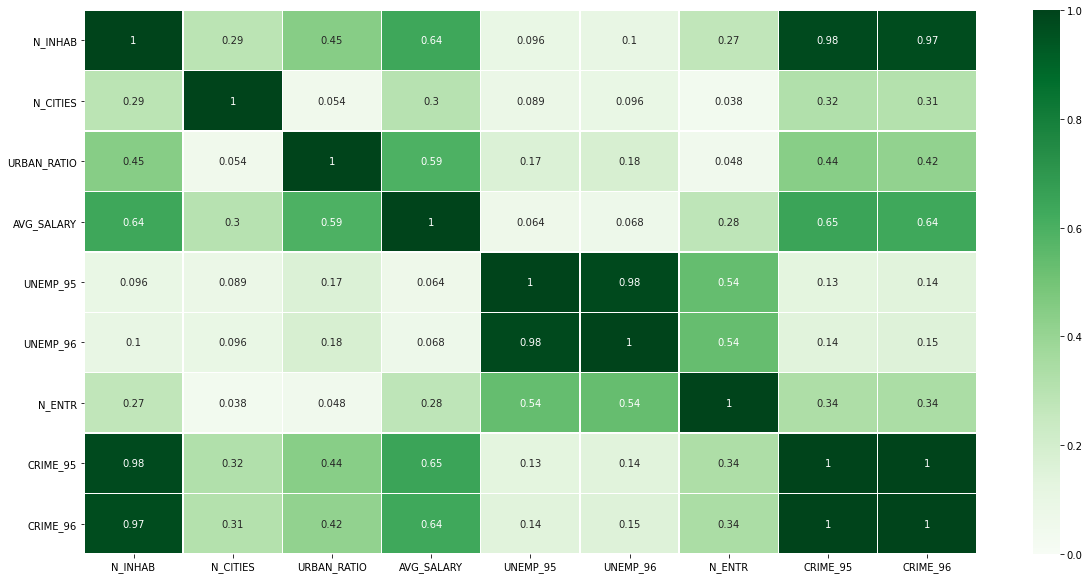

In [71]:
plt.figure(figsize=(20,10))
sns.heatmap(abs(dfDistrictsModel.corr()), vmin = 0, vmax = 1, cmap = "Greens", linewidths=0.5, annot=True)

It is observed that linear relationship between "UNEMP_95" and "UNEMP_96" are strong. That's why, a simple linear regression model can be used to predict missing value.

In [72]:
aX = np.array(dfDistrictsModel["UNEMP_96"]).reshape(-1,1)
aY = np.array(dfDistrictsModel["UNEMP_95"]).reshape(-1,1)

oLinRegModel = LinearRegression()

oLinRegModel.fit(aX, aY)

aUnemp95ToPredict = dfDistricts[dfDistricts["UNEMP_95"] == "?"].loc[:, "UNEMP_96"]
aUnemp95ToPredict = np.array(aUnemp95ToPredict).reshape(-1,1)

aUnemp95Predicted = oLinRegModel.predict(aUnemp95ToPredict)

There is a linear relationship between "CRIME_95", "CRIME_96" and "N_INHAB" fields. That's why, a simple linear regression model can be used to predict missing value.

In [73]:
aX = np.array(np.array(dfDistrictsModel[["CRIME_96", "N_INHAB"]]))
aY = np.array(dfDistrictsModel["CRIME_95"]).reshape(-1,1)

oLinRegModel = LinearRegression()

oLinRegModel.fit(aX, aY)

aCrime95ToPredict = dfDistricts[dfDistricts["CRIME_95"] == "?"].loc[:,["CRIME_96", "N_INHAB"]]
aCrime95ToPredict = np.array(aCrime95ToPredict)

aCrime95Predicted = oLinRegModel.predict(aCrime95ToPredict)

In order to replace question marks with predicted valeus,  missing rows are added back to dfDistrictsModel.

In [74]:
dfDistrictsModel= dfDistrictsModel.append(dfMissingRows)
dfDistrictsModel.sort_index(inplace=True)

Predicted valeus are added to missing rows.

In [75]:
dfMaskMissingUnemp95s = dfDistrictsModel["UNEMP_95"] == "?"
dfDistrictsModel.loc[dfMaskMissingUnemp95s,"UNEMP_95"] = aUnemp95Predicted

In [76]:
dfMaskMissingCrime95s = dfDistrictsModel["CRIME_95"] == "?"
dfDistrictsModel.loc[dfMaskMissingCrime95s,"CRIME_95"] = aCrime95Predicted

Now those columns can be converted to numerical type.

In [77]:
dfDistrictsModel["UNEMP_95"] = dfDistrictsModel["UNEMP_95"].astype(np.float64)
dfDistrictsModel["CRIME_95"] = dfDistrictsModel["CRIME_95"].astype(np.int64)

dfDistrictsModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_INHAB      77 non-null     int64  
 1   N_CITIES     77 non-null     int64  
 2   URBAN_RATIO  77 non-null     float64
 3   AVG_SALARY   77 non-null     int64  
 4   UNEMP_95     77 non-null     float64
 5   UNEMP_96     77 non-null     float64
 6   N_ENTR       77 non-null     int64  
 7   CRIME_95     77 non-null     int64  
 8   CRIME_96     77 non-null     int64  
dtypes: float64(3), int64(6)
memory usage: 6.0 KB


### ACCOUNT_ID

There are 4915 rows that don't have value in "ACCOUNT_ID" field. This is not a big amount for this database. It wouldn't be very reliable to predict ACCOUNT_ID. That's why, those rows are dropped from dfTransactionsModel.

In [78]:
dfMissingAccountIds = dfTransactionsModel[dfTransactionsModel["ACCOUNT_ID"].isna()]

In [79]:
dfMissingAccountIds

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
1190752,NaN,1993-01-30,300.0,300.0,CREDIT,CREDIT_IN_CASH
1132664,NaN,1993-02-06,4356.0,4656.0,CREDIT,COLLECTION_FROM_OTHER_BANK
711470,NaN,1993-02-19,500.0,500.0,CREDIT,CREDIT_IN_CASH
2524756,NaN,1993-03-28,600.0,600.0,CREDIT,CREDIT_IN_CASH
685667,NaN,1993-04-05,3247.0,6894.0,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...
573665,NaN,1998-12-14,2080.0,48370.1,WITHDRAWAL,WITHDRAWAL_IN_CASH
823968,NaN,1998-12-14,2400.0,60471.9,WITHDRAWAL,WITHDRAWAL_IN_CASH
556532,NaN,1998-12-14,35859.0,89165.0,CREDIT,CREDIT_IN_CASH


In [80]:
dfTransactionsModel.drop(dfMissingAccountIds.index, inplace = True)

"ACCOUNT_ID" field is converted to integer format to be allign with dfCustomers's "ACCOINT_ID" field.

In [81]:
dfTransactionsModel["ACCOUNT_ID"] = dfTransactionsModel["ACCOUNT_ID"].astype(np.int64)

### OPERATION

In [82]:
dfTransactionsMissingOperation = dfTransactionsModel[dfTransactionsModel["OPERATION"].isna()]

In [83]:
dfTransactionsMissingOperation

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
3602138,2177,1993-01-31,21.5,5944.5,CREDIT,NaN
3595783,1972,1993-01-31,19.1,5717.1,CREDIT,NaN
3594124,1926,1993-01-31,14.0,5221.0,CREDIT,NaN
3648651,3592,1993-01-31,19.5,6626.5,CREDIT,NaN
3645341,3487,1993-01-31,42.7,16756.7,CREDIT,NaN
...,...,...,...,...,...,...
3632826,3097,1998-12-31,43.7,10571.3,CREDIT,NaN
3630290,3017,1998-12-31,113.7,32446.6,CREDIT,NaN
3629757,2998,1998-12-31,184.7,47355.6,CREDIT,NaN


"TYPE" field of all of the missing values are "CREDIT". When all data is checked, "CREDIT" type can have 2 possible "OPERATION":

1. COLLECTION_FROM_OTHER_BANK
or
2. CREDIT_IN_CASH

In [84]:
dfTransactionsMissingOperation["TYPE"].unique()

array(['CREDIT'], dtype=object)

In [85]:
dfTransactionsModel[["TYPE", "OPERATION", "AMOUNT"]].groupby(["TYPE", "OPERATION"]).agg(["count", "min", "max"])

AMOUNT                 
                                        count     min      max
TYPE       OPERATION                                          
CREDIT     COLLECTION_FROM_OTHER_BANK   64243  2900.0  74812.0
           CREDIT_IN_CASH              154111   100.0  49999.0
WITHDRAWAL CC_WITHDRAWAL                 7858   100.0   8000.0
           REMITTANCE_TO_OTHER_BANK    205306     1.0  14882.0
           WITHDRAWAL_IN_CASH          427470     0.0  87400.0

A decision classifier can be used to predict missing "OPERATION" values. In order to train the classifier, it would be enough to use only the transactions that have "CREDIT" type. And "TYPE" field doesn't need to be an input feature since it is always same for all missing data.

In [86]:
dfTransactionsNonMissingOperation = dfTransactionsModel.drop(dfTransactionsMissingOperation.index)
dfTransactionsNonMissingOperation = dfTransactionsNonMissingOperation[dfTransactionsNonMissingOperation["TYPE"] == "CREDIT"]

In [87]:
dfX = dfTransactionsModel[dfTransactionsModel["TYPE"] == "CREDIT"].copy()

dfX.drop(["TYPE", "OPERATION", "DATE"], axis = 1, inplace=True)

dfX["TRANSACTION_YEAR"] = dfTransactionsModel["DATE"].dt.year
dfX["TRANSACTION_MONTH"] = dfTransactionsModel["DATE"].dt.month
dfX["TRANSACTION_DAY"] = dfTransactionsModel["DATE"].dt.day

In [88]:
dfX

,ACCOUNT_ID,AMOUNT,BALANCE,TRANSACTION_YEAR,TRANSACTION_MONTH,TRANSACTION_DAY
TRANS_ID,,,,,,
695247,2378,700.0,700.0,1993,1,1
171812,576,900.0,900.0,1993,1,1
207264,704,1000.0,1000.0,1993,1,1
1117247,3818,600.0,600.0,1993,1,1
579373,1972,400.0,400.0,1993,1,2
...,...,...,...,...,...,...
3632826,3097,43.7,10571.3,1998,12,31
3630290,3017,113.7,32446.6,1998,12,31
3629757,2998,184.7,47355.6,1998,12,31


In [89]:
dfY = pd.get_dummies(dfTransactionsModel[dfTransactionsModel["TYPE"] == "CREDIT"]["OPERATION"])

In [90]:
dfY

,COLLECTION_FROM_OTHER_BANK,CREDIT_IN_CASH
TRANS_ID,,
695247,0,1
171812,0,1
207264,0,1
1117247,0,1
579373,0,1
...,...,...
3632826,0,0
3630290,0,0
3629757,0,0


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    dfX.loc[dfTransactionsNonMissingOperation.index], 
    dfY.loc[dfTransactionsNonMissingOperation.index], 
    test_size=0.3, 
    random_state=1, 
    shuffle=True)

In [92]:
oDecTreeModel =  DecisionTreeClassifier()
oDecTreeModel.fit(X_train, y_train)

y_pred = oDecTreeModel.predict(X_test)

y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = y_test.columns )

Both classes have good accuracy and f1 score meaning that decision tree model may able to predict both True Positives and True Negatives.

In [93]:
print(classification_report(y_test, y_pred, target_names=dfY.columns))

for sClass in dfY.columns:
    print(f"Accuracy of : " + sClass + ": "+ str(round(metrics.accuracy_score(y_test[sClass], y_pred[sClass]), 2))) 

                            precision    recall  f1-score   support

COLLECTION_FROM_OTHER_BANK       0.95      0.97      0.96     19259
            CREDIT_IN_CASH       0.99      0.98      0.98     46248

                 micro avg       0.98      0.98      0.98     65507
                 macro avg       0.97      0.97      0.97     65507
              weighted avg       0.98      0.98      0.98     65507
               samples avg       0.98      0.98      0.98     65507

Accuracy of : COLLECTION_FROM_OTHER_BANK: 0.98
Accuracy of : CREDIT_IN_CASH: 0.98


All of the missing values are predicted as "CREDIT_IN_CASH" value.

In [94]:
aPredictionsForMissingOperations = oDecTreeModel.predict(dfX.loc[dfTransactionsMissingOperation.index])
dfPredictionsForMissingOperations = pd.DataFrame(data = aPredictionsForMissingOperations, columns = dfY.columns, index = dfTransactionsMissingOperation.index)

aPredictedOperations = dfPredictionsForMissingOperations.idxmax(axis=1)

dfTransactionsModel.loc[dfTransactionsMissingOperation.index,"OPERATION"] = aPredictedOperations

In [95]:
aPredictedOperations.unique()

array(['CREDIT_IN_CASH'], dtype=object)

# DATA ANALYSIS

## Time Series Analysis

In [96]:
dfAnalysis = dfTransactionsModel[["DATE", "AMOUNT"]].groupby(["DATE"], as_index = False).agg(["count", "mean"])["AMOUNT"].reset_index()

In [97]:
dfAnalysis

,DATE,count,mean
0,1993-01-01,4,800.000000
1,1993-01-02,2,750.000000
2,1993-01-03,4,775.000000
3,1993-01-04,4,650.000000
4,1993-01-05,3,3074.666667
...,...,...,...
2186,1998-12-27,255,8081.286275
2187,1998-12-28,216,7442.564815
2188,1998-12-29,236,7144.991525
2189,1998-12-30,237,7854.481013


1. There is a seasonality in average amount of payment. 
2. Behavior of average payment doesn't change much after 1994. But there is a high deviation on average payment in 1993's 1st half. 
3. On every January, average payment goes down.

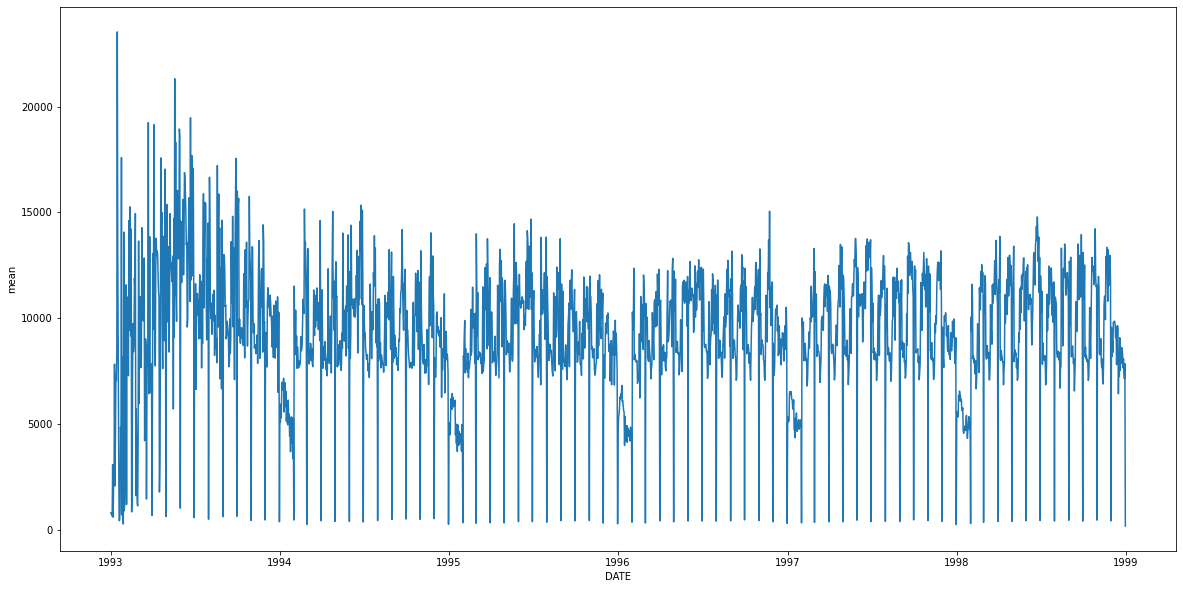

In [98]:
plt.figure(figsize=(20,10))
sns.lineplot(data = dfAnalysis, 
             x = "DATE", 
             y = "mean")

In some dates, average "AMOUNT" is less than 1k. When year, 1998 is checked, it is observed that those are the end dates of each month.

In [99]:
dfAnalysis[(dfAnalysis["mean"] < 1000) & (dfAnalysis["DATE"].dt.year == 1998)]

,DATE,count,mean
1856,1998-01-31,8742,299.129776
1884,1998-02-28,8894,362.757005
1915,1998-03-31,8912,399.292751
1945,1998-04-30,8994,400.146275
1976,1998-05-31,9039,429.527835
2006,1998-06-30,9124,441.158253
2037,1998-07-31,9074,417.454166
2068,1998-08-31,9071,456.856190
2098,1998-09-30,9097,413.743223
2129,1998-10-31,9058,460.839810


1. There is an upwards-trend for the number of the payments. 
2. At the last day of each month, number of payment increases.
3. During 5th-15th of each month, number of payments are higher than other days (except latest day of month).

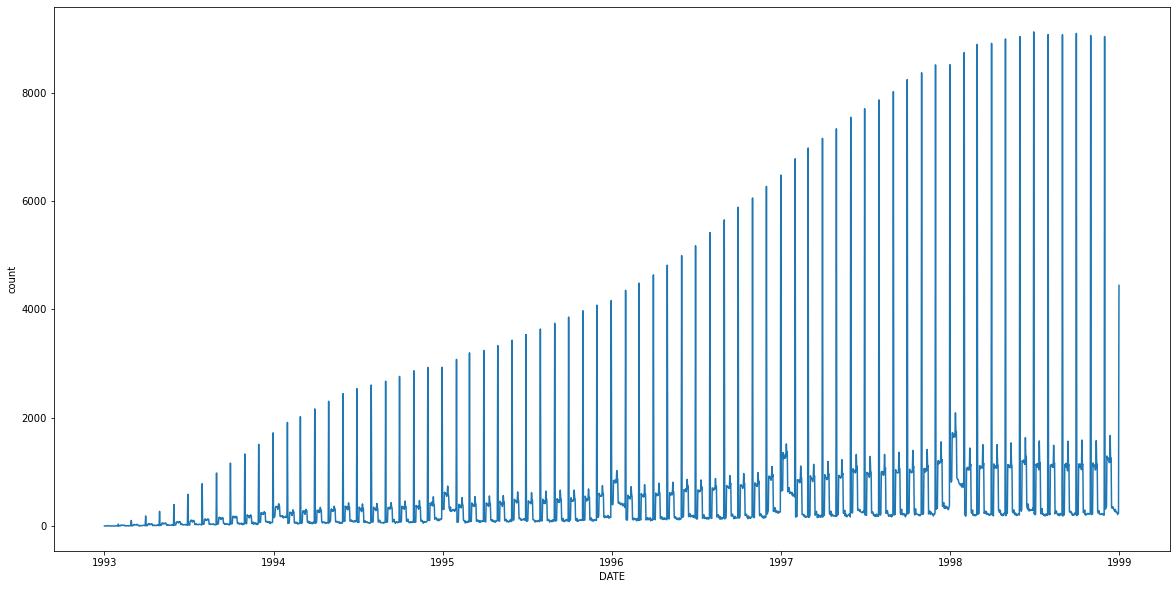

In [100]:
plt.figure(figsize=(20,10))
sns.lineplot(data = dfAnalysis, 
             x = "DATE", 
             y = "count")

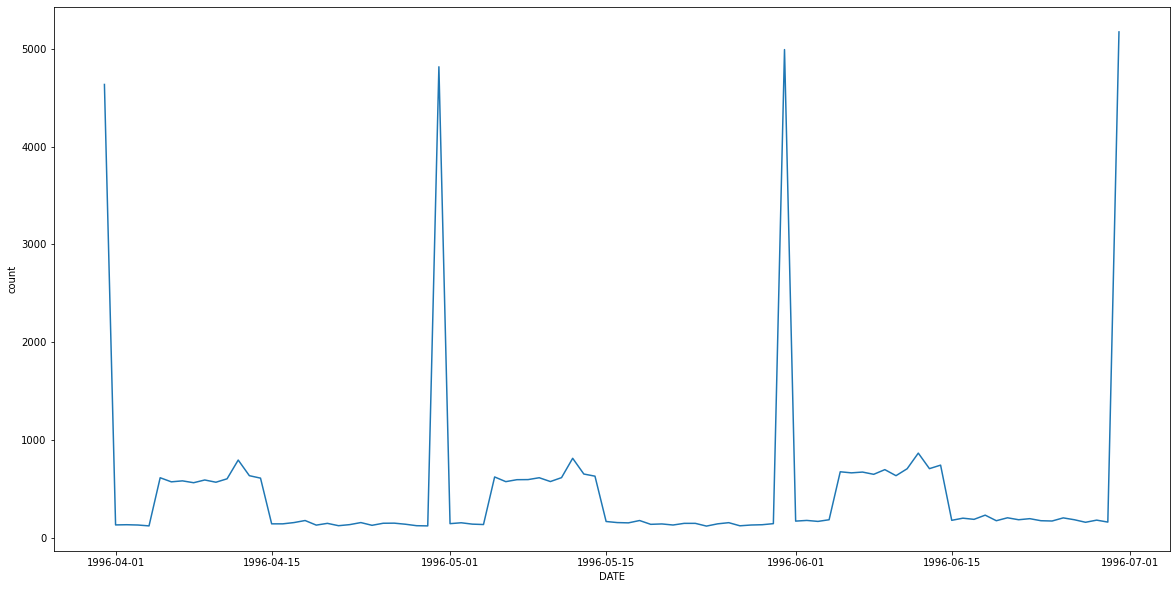

In [101]:
plt.figure(figsize=(20,10))
sns.lineplot(data = dfAnalysis[(dfAnalysis["DATE"] > "1996-03-30") & (dfAnalysis["DATE"] < "1996-07-01")], 
             x = "DATE", 
             y = "count")

## Customer Profile Analysis

In [102]:
dfMaskTransaction1996 = dfTransactionsModel["DATE"].dt.year == 1996
dfMaskTransctionsCredit = dfTransactionsModel["TYPE"] =="CREDIT"
dfMaskTransctionsWithdrawal = dfTransactionsModel["TYPE"] =="WITHDRAWAL"

dfTransactions1996 = dfTransactionsModel[dfMaskTransaction1996]
dfTransactionsCredit1996 = dfTransactionsModel[dfMaskTransaction1996 & dfMaskTransctionsCredit]
dfTransactionsWithdrawal1996 = dfTransactionsModel[dfMaskTransaction1996 & dfMaskTransctionsWithdrawal]

In [103]:
dfBalances1996 = dfTransactions1996[["ACCOUNT_ID", "BALANCE"]].groupby(["ACCOUNT_ID"]).agg(["mean"])

In [104]:
dfCredits1996 = dfTransactionsCredit1996[["ACCOUNT_ID", "AMOUNT"]].groupby(["ACCOUNT_ID"]).agg(["count", "sum", "mean"])

dfCredits1996.columns = dfCredits1996.columns.set_levels(["CREDIT AMAOUNT"], level = 0)

In [105]:
dfWithdrawals1996 = dfTransactionsWithdrawal1996[["ACCOUNT_ID", "AMOUNT"]].groupby(["ACCOUNT_ID"]).agg(["count","sum","mean"])

dfWithdrawals1996.columns = dfWithdrawals1996.columns.set_levels(["WITHDRAWAL AMAOUNT"], level = 0)

In [106]:
dfTransactionSummary1996 = dfBalances1996.join(dfCredits1996, how = "left")
dfTransactionSummary1996 = dfTransactionSummary1996.join(dfWithdrawals1996, how = "left")
dfTransactionSummary1996.columns = ['_'.join(col) for col in dfTransactionSummary1996.columns.values]
dfTransactionSummary1996

,BALANCE_mean,CREDIT AMAOUNT_count,CREDIT AMAOUNT_sum,CREDIT AMAOUNT_mean,WITHDRAWAL AMAOUNT_count,WITHDRAWAL AMAOUNT_sum,WITHDRAWAL AMAOUNT_mean
ACCOUNT_ID,,,,,,,
1,15980.927027,29.0,50066.0,1726.413793,45.0,55579.2,1235.093333
2,36604.402353,29.0,288542.9,9949.755172,56.0,274574.2,4903.110714
4,23648.623077,17.0,56920.5,3348.264706,22.0,31977.6,1453.527273
6,30635.530645,24.0,81507.7,3396.154167,38.0,81788.6,2152.331579
7,23088.850000,3.0,34905.4,11635.133333,1.0,6600.0,6600.000000
...,...,...,...,...,...,...,...
11333,44781.881818,43.0,426027.5,9907.616279,45.0,407902.4,9064.497778
11349,52672.669318,25.0,551271.3,22050.852000,63.0,542689.0,8614.111111
11359,28716.853684,24.0,352777.0,14699.041667,71.0,351816.7,4955.164789


In [107]:
dfAnalysis = dfCustomersModel.reset_index().merge(dfTransactionSummary1996, how = "inner", on = "ACCOUNT_ID")
dfAnalysis = dfAnalysis.merge(dfDistrictsModel, on = "DISTRICT_ID", how = "inner")

dfAnalysis["CUSTOMER_AGE"] = 1996 - dfAnalysis["BIRTH_DT"].dt.year

dfAnalysis.drop(["CLIENT_ID", "DISTRICT_ID", "ACCOUNT_ID", "BIRTH_DT", "SET_SPLIT", "CRIME_95", "UNEMP_95", "ACTIVE"], axis = 1, inplace=True)

In [108]:
dfAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3514 entries, 0 to 3513
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GENDER                    3514 non-null   object 
 1   LOAN                      3514 non-null   int64  
 2   BALANCE_mean              3514 non-null   float64
 3   CREDIT AMAOUNT_count      3513 non-null   float64
 4   CREDIT AMAOUNT_sum        3513 non-null   float64
 5   CREDIT AMAOUNT_mean       3513 non-null   float64
 6   WITHDRAWAL AMAOUNT_count  3218 non-null   float64
 7   WITHDRAWAL AMAOUNT_sum    3218 non-null   float64
 8   WITHDRAWAL AMAOUNT_mean   3218 non-null   float64
 9   N_INHAB                   3514 non-null   int64  
 10  N_CITIES                  3514 non-null   int64  
 11  URBAN_RATIO               3514 non-null   float64
 12  AVG_SALARY                3514 non-null   int64  
 13  UNEMP_96                  3514 non-null   float64
 14  N_ENTR  

There is no linear relationship between district features v.s. average&sum transaction quantities. That's why, district related features are excluded from dfAnalysis.

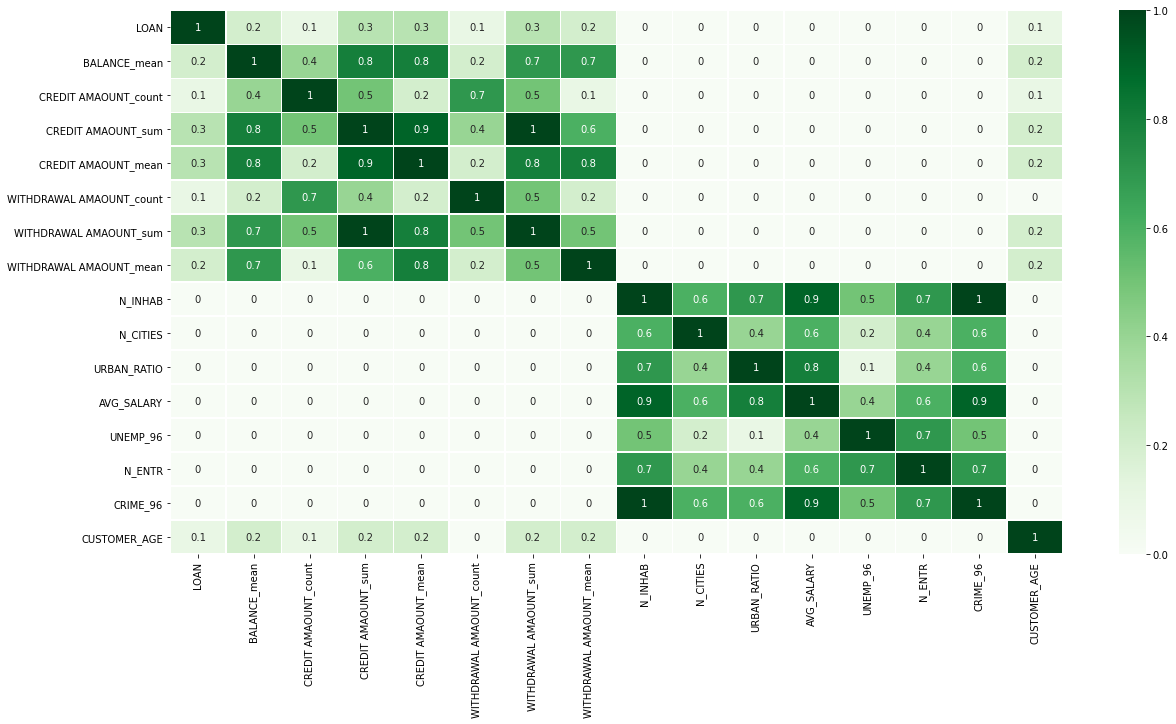

In [109]:
plt.figure(figsize=(20,10))
sns.heatmap(round(abs(dfAnalysis.corr()),1), vmin=0, vmax=1,  cmap = "Greens", linewidths=0.5, annot=True)

In [110]:
dfAnalysis.drop(['N_INHAB','N_CITIES', 'URBAN_RATIO', 'AVG_SALARY', 'UNEMP_96', 'N_ENTR','CRIME_96'], axis = 1, inplace=True)

BALANCE_mean distribution plot: 
1. Average balances of the customers who have loan is similar to the ones who didn't have loan. 
2. Number of customers who have loan are less than the the ones who don't have loan.

BALANCE_mean vs. CREDIT_AMOUNT_sum: 
1. The customers who took loan has similar CREDIT_AMOUNT_sum to their BALANCE_mean.
2. The customers that didn't take loan has relatively smaller CREDIT_AMOUNT_sum.

BALANCE_mean vs. CUSTOMER_AGE: 
1. The customers that are under 20: 
    1. They don't have any loan almost. 
2. The customers that are between 20-40:
    1. mainly the customers that have over 60k balance have loan. 
3. The customers between 40-60 ages:
    1. loan is distributed more homogeneously than customers that are in age 20-40.
4. The customers over 60:
    1. They don't have loan. 
    2. They have almost half balance than other customer profiles. 

CREDIT_AMOUNT_count distribution plot: 
1. Plot has 3 hills. It s a sign that there are clusters based on CREDIT_AMOUNT_count. 
2. CREDIT_AMOUNT_count can be categorized: 
    1. less than 20 transactions
    2. 20-40 transactions
    3. 40+ transactions

CREDIT_AMOUNT_count vs. CUSTOMER_AGE: 
1. Customers over 60, have half number of credits compared to other customers.

CREDIT_AMOUNT_sum distribution plot: 
1. Customers that have less than 500k,
    1. number of the customers that don't have loan is more than the other ones. 
2. Customers that have more than 500k, 
    1. CREDIT_AMOUNT_sum have almost same amount of customers that are loaned and not loaned. 
3. Plot has 3 hills. We can categorize them as:
    1. less than 200k
    2. 200k-500k
    3. 500k+

CREDIT_AMOUNT_sum vs. WITHDRAWAL_AMOUNT_sum:
1. There is a strong linear relationship between them regardless loan status.

CREDIT_AMOUNT_sum vs. CUSTOMER_AGE: 
1. The customers over 60
    1. have 4 times less CREDIT_AMOUNT_sum than the other customers. 
    2. This ratio was 2 about CREDIT_AMOUNT_count and BALANCE_mean. 
2. Customers that are less than 60 years old
    1. customers that have CREDIT_AMOUNT_sum  more than 200k, 
        1. mostly have loan 
    2. customers that have CREDIT_AMOUNT_sum less than 200k,
        1. mostly don't have loan.

WITHDRAWAL_AMOUNT_count distribution plot: 
1. Customers that don't have loan withdraw more times than the ones that have loan. 
2. There are 2 hills on distribution plot. WITHDRAWAL_AMOUNT_count can be categorized as:
    1. less than 25 transactions
    2. 25+ transactions
3. Customers that have less than 500k transactions,
    1. Number of non-loaned customers are less than loaned customers.
4. Customers that have more than 500k transactions,
    1. Number of loaned and non-loaned customers are close to each other.

CUSTOMER_AGE distribution plot:
1. Based on the hills of plot, CUSTOMER_AGE can be categorized as follows:
    1. Less than 20 age
    2. 20-40 age
    3. 40-60 age
    4. 60+ age.

<Figure size 1440x720 with 0 Axes>

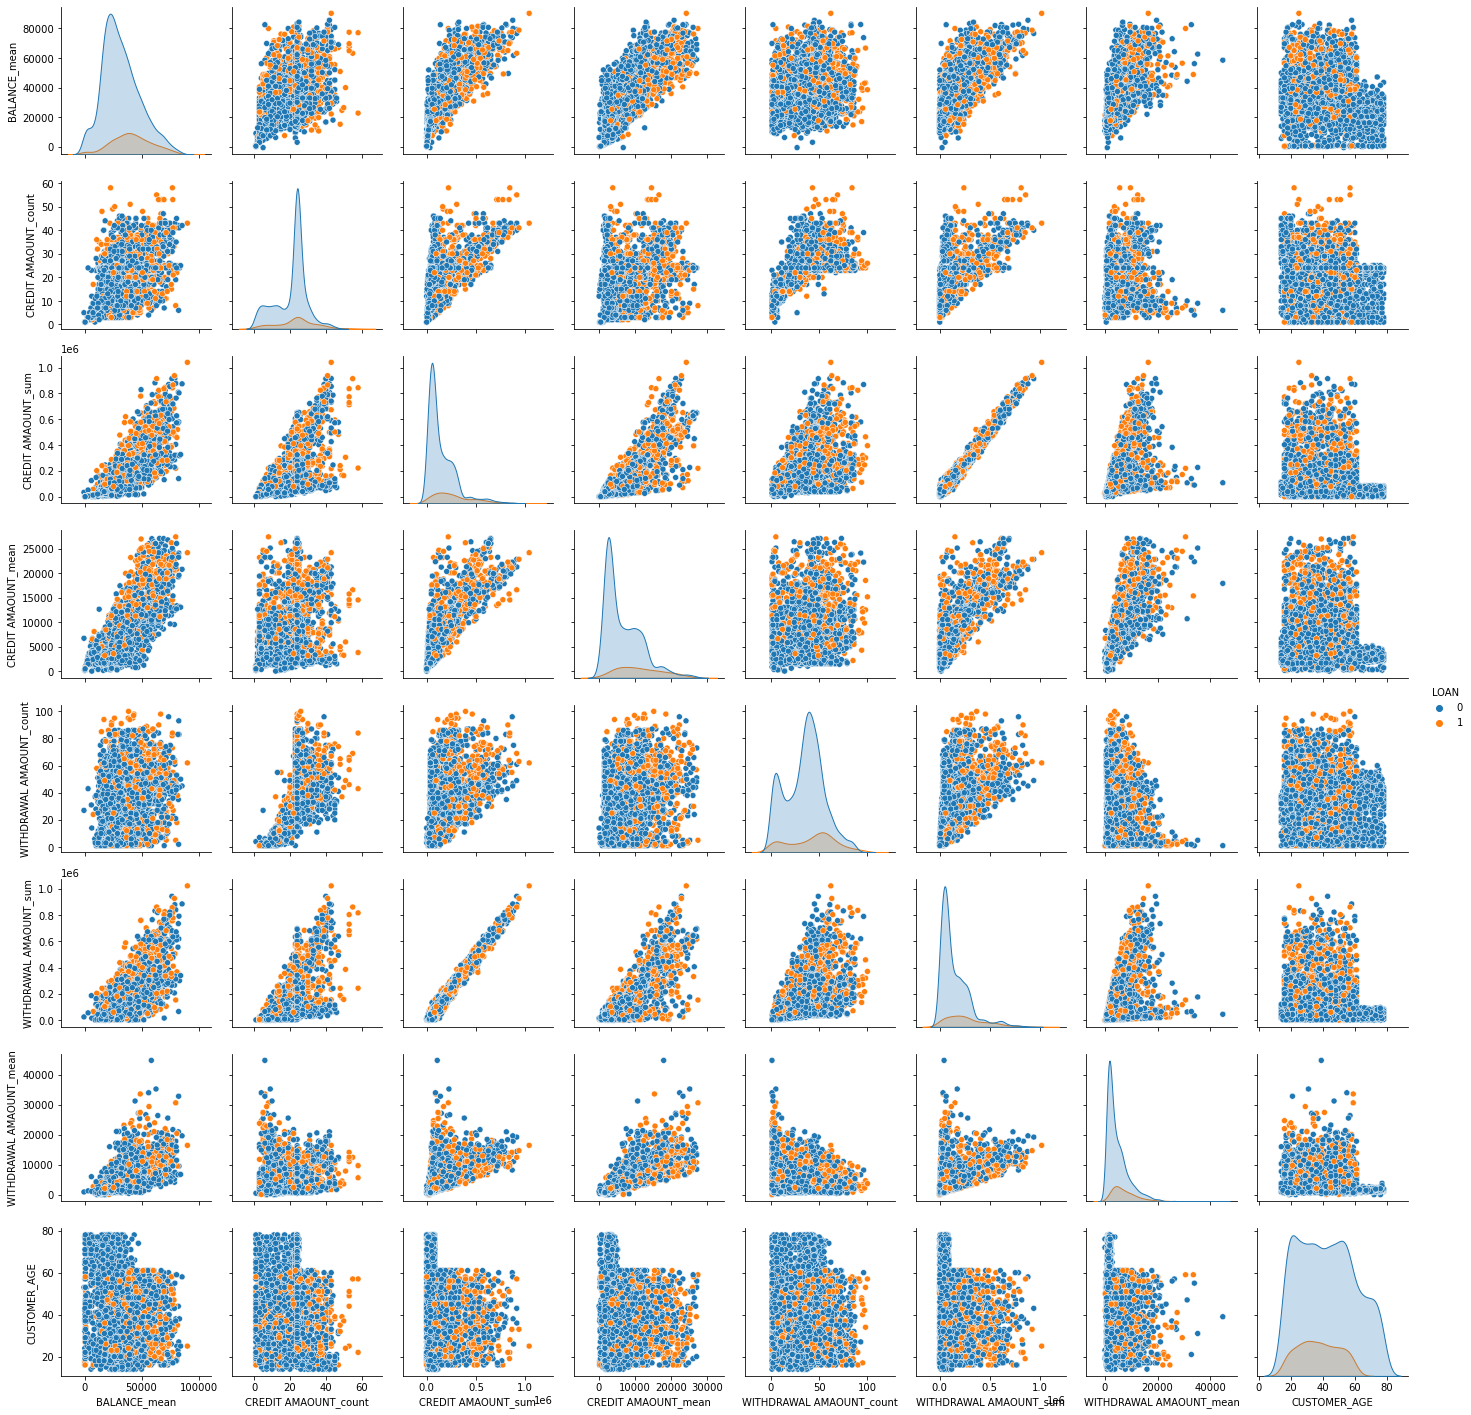

In [111]:
plt.figure(figsize=(20,10))

sns.pairplot(
    data=dfAnalysis,
    hue = "LOAN"
)

Gender doesn't matter on customer behavior. For example, CREDIT_AMOUNT_sum has similar pattern for both male and female customers.

<Figure size 1440x720 with 0 Axes>

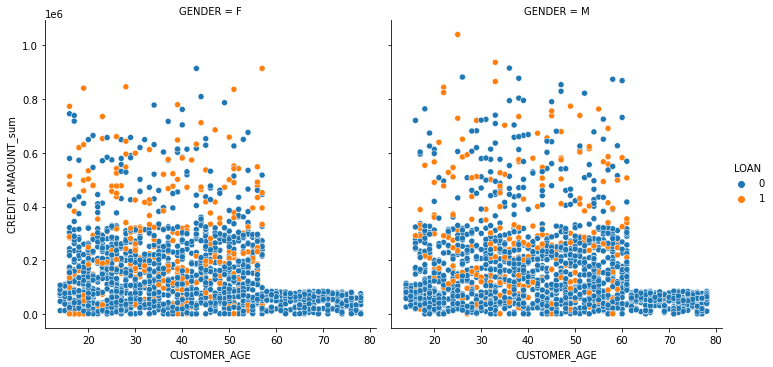

In [112]:
plt.figure(figsize=(20,10))

sns.relplot(
    data=dfAnalysis, 
    x = "CUSTOMER_AGE", 
    y = "CREDIT AMAOUNT_sum", 
    hue = "LOAN",
    col="GENDER", 
    kind="scatter"
)

## Geographical District Analysis

In [170]:
dfAnalysis = dfTransactionsModel[dfTransactionsModel["DATE"].dt.year == 1996]
dfAnalysis = dfTransactionsModel.reset_index().merge(dfCustomersModel.reset_index(), on = "ACCOUNT_ID", how = "inner").set_index("TRANS_ID")
dfAnalysis = dfAnalysis.reset_index().merge(dfDistrictsModel.reset_index(), on = "DISTRICT_ID", how = "inner").set_index("TRANS_ID")
dfAnalysis.drop(["DATE", "GENDER", "BIRTH_DT", "ACTIVE", "SET_SPLIT",'N_CITIES', 'URBAN_RATIO',
       'AVG_SALARY', 'UNEMP_95', 'UNEMP_96', 'N_ENTR', 'CRIME_95', 'CRIME_96'], axis = 1, inplace = True)

In [171]:
dfAnalysis.head()

,ACCOUNT_ID,AMOUNT,BALANCE,TYPE,OPERATION,CLIENT_ID,LOAN,DISTRICT_ID,N_INHAB
TRANS_ID,,,,,,,,,
695247,2378,700.0,700.0,CREDIT,CREDIT_IN_CASH,2873,0,16,93931
695250,2378,7268.0,7968.0,CREDIT,CREDIT_IN_CASH,2873,0,16,93931
695266,2378,14440.0,22408.0,CREDIT,CREDIT_IN_CASH,2873,0,16,93931
695262,2378,49752.0,72160.0,CREDIT,CREDIT_IN_CASH,2873,0,16,93931
695265,2378,21899.0,94059.0,CREDIT,CREDIT_IN_CASH,2873,0,16,93931


1. COLLECTION_FROM_OTHER_BANK: Average amount of transactions is NOT distributed homogeneously among districts. 

2. CC_WITHDRAWAL and REFERENCE_TO_OTHER_BANK: Average amount of transactions are distributed more homogeneously than other operations. 

Text(0.5, 1.0, 'AVERAGE TRANSACTION AMOUNTS')

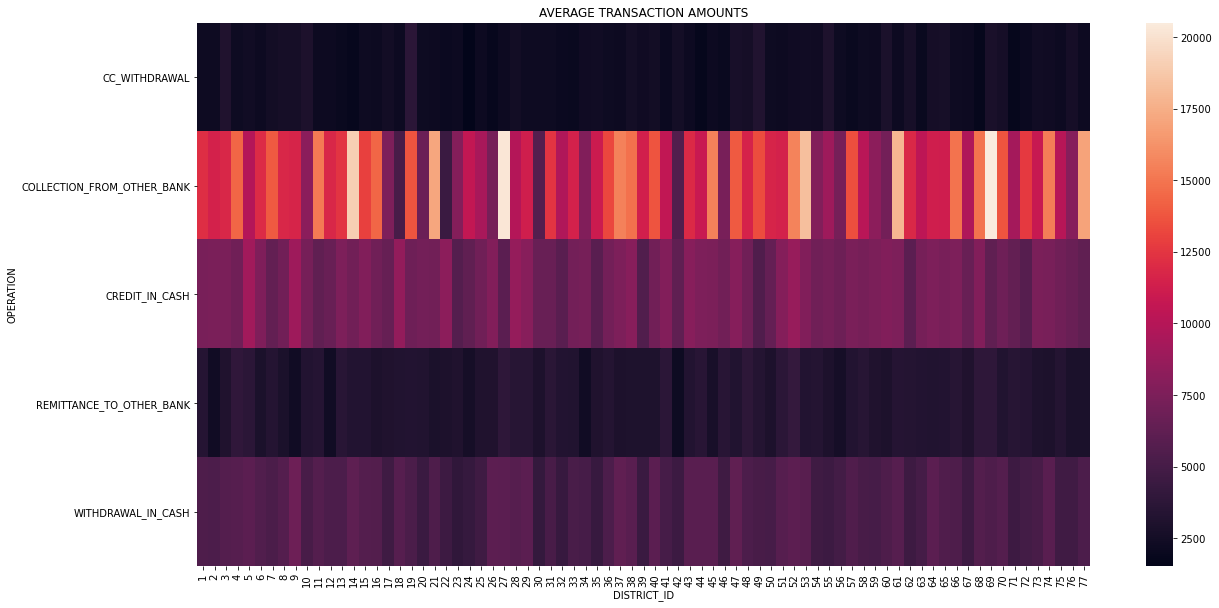

In [197]:
plt.figure(figsize=(20,10))
oFig = sns.heatmap(data = dfAnalysis.pivot_table(
    columns = "DISTRICT_ID", 
    index="OPERATION", 
    values="AMOUNT", 
    aggfunc="mean"))


oFig.set_title("AVERAGE TRANSACTION AMOUNTS")

Text(0.5, 1.0, 'STANDARD DEVIATION OF TRANSACTION AMOUNTS')

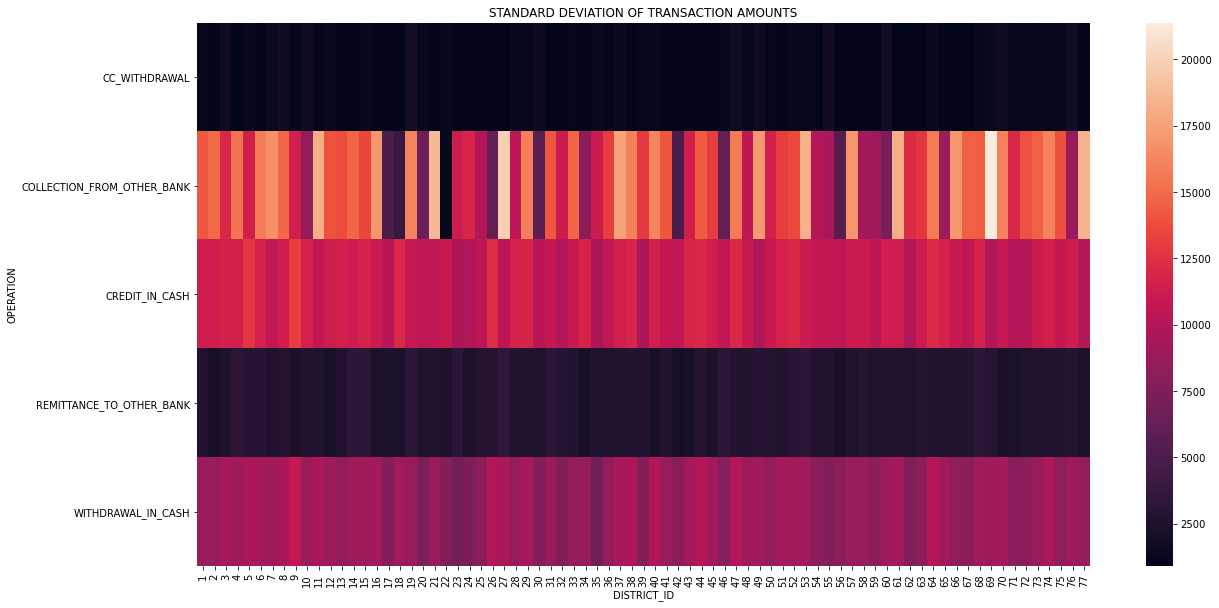

In [198]:
plt.figure(figsize=(20,10))
oFig = sns.heatmap(data = dfAnalysis.pivot_table(
    columns = "DISTRICT_ID", 
    index="OPERATION", 
    values="AMOUNT", 
    aggfunc="std"))


oFig.set_title("STANDARD DEVIATION OF TRANSACTION AMOUNTS")

1. CC_WITHDRAWAL: Number of transactions per inhabitant is distributed homogeneously.
2. Other "OPERATION" types: Number of transactions per inhabitant is NOT distributed homogeneously.

Text(0.5, 1.0, 'NUMBER OF TRANSACTIONS PER INHABITANT')

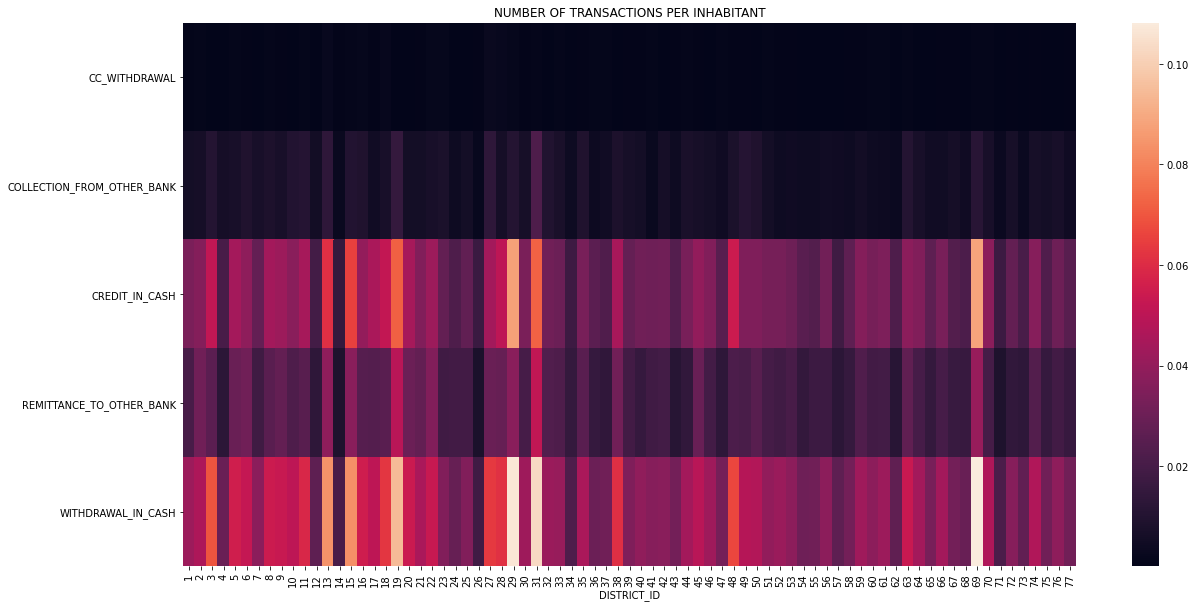

In [195]:
dfAnalysis2 = dfAnalysis.reset_index().pivot_table(
    index="DISTRICT_ID", 
    columns="OPERATION", 
    values="TRANS_ID", 
    aggfunc="count")


dfAnalysis2= dfAnalysis2.merge(dfDistrictsModel["N_INHAB"], how = "inner", on="DISTRICT_ID")
dfAnalysis2 = dfAnalysis2.div(dfAnalysis2["N_INHAB"], axis=0)
dfAnalysis2.drop(["N_INHAB"], axis = 1 , inplace = True)
plt.figure(figsize=(20,10))

oFig = sns.heatmap(data = dfAnalysis2.transpose())
oFig.set_title("NUMBER OF TRANSACTIONS PER INHABITANT")

# PREDICTIVE MODEL

In [199]:
dfAnalysis =dfTransactionsModel.pivot_table(index = "ACCOUNT_ID", columns="OPERATION", values="AMOUNT")
dfAnalysis.fillna(0, inplace=True)

dfTransacitonSummary = dfTransactionsModel[["BALANCE", "ACCOUNT_ID"]].groupby(["ACCOUNT_ID"]).agg(["count", "mean"])["BALANCE"]
dfTransacitonSummary.columns =["NUMBER_OF_TRANSACTIONS", "BALANCE_AVERAGE"]


dfAnalysis = dfAnalysis.merge(dfTransacitonSummary,  how = "inner", on = "ACCOUNT_ID")

In [200]:
dfAnalysis = dfAnalysis.merge(dfCustomersModel, how = "inner", on = "ACCOUNT_ID")
dfAnalysis["CUSTOMER_AGE"] = 1996- dfAnalysis["BIRTH_DT"].dt.year

In [201]:
dfAnalysis= dfAnalysis.merge(dfDistrictsModel, how = "inner", on = "DISTRICT_ID")

In [202]:
dfAnalysis.drop(["ACCOUNT_ID", "GENDER", "BIRTH_DT", "DISTRICT_ID"], axis=1, inplace=True)

## Split Dataset

In [203]:
dfTrainX = dfAnalysis[dfAnalysis["SET_SPLIT"] == "TRAIN"].drop(["SET_SPLIT", "LOAN"], axis = 1)
dfTrainY = dfAnalysis[dfAnalysis["SET_SPLIT"] == "TRAIN"]["LOAN"]
dfTestX = dfAnalysis[dfAnalysis["SET_SPLIT"] == "TEST"].drop(["SET_SPLIT", "LOAN"], axis = 1)
dfTestY = dfAnalysis[dfAnalysis["SET_SPLIT"] == "TEST"]["LOAN"]

## Oversample Imbalance Dataset

Training dataset's class 0 and 1 are balanced.

In [204]:
dfCombinations = dfTrainY
dfCombinationsStats = dfCombinations.value_counts()
dfCombinationsStats = pd.DataFrame(dfCombinationsStats).reset_index()

iMaxAmount = dfCombinationsStats.iloc[0,1]
for i in range(1, len(dfCombinationsStats) ):

    sCombination = dfCombinationsStats.iloc[i, 0]
    iSamplesNeeded = iMaxAmount - dfCombinationsStats.iloc[i, 1]

    dfSampledIndex =  dfCombinations[dfCombinations == sCombination].sample(iSamplesNeeded, replace = True).index

    dfSampledX = dfTrainX.loc[dfSampledIndex]
    dfSampledY = dfTrainY.loc[dfSampledIndex]


    dfTrainX = dfTrainX.append(dfSampledX , ignore_index= True)
    dfTrainY = dfTrainY.append(dfSampledY , ignore_index= True)


dfTrainX,dfTrainY = shuffle(dfTrainX,dfTrainY,random_state=1 )

In [205]:
dfTrainY.value_counts()

0    2992
1    2992
Name: LOAN, dtype: int64

## Logistic Regression

### Train

In [206]:
oLogRegModel =  LogisticRegression(max_iter=10000)
oLogRegModel.fit(dfTrainX, dfTrainY)

LogisticRegression(max_iter=10000)

In [207]:
aPredictedLogReg = oLogRegModel.predict(dfTrainX)
dfPredictedLogReg = pd.DataFrame(aPredictedLogReg, index = dfTrainX.index, columns = ["LOAN"])
print(classification_report(dfTrainY, aPredictedLogReg))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      2992
           1       0.72      0.71      0.72      2992

    accuracy                           0.72      5984
   macro avg       0.72      0.72      0.72      5984
weighted avg       0.72      0.72      0.72      5984



### Test

In [208]:
aPredictedLogRegProbability = oLogRegModel.predict_proba(dfTestX)
aPredictedLogReg = oLogRegModel.predict(dfTestX)
dfPredictedLogReg = pd.DataFrame(aPredictedLogReg, index = dfTestX.index, columns = ["LOAN"])
print(classification_report(dfTestY, aPredictedLogReg))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80       748
           1       0.28      0.66      0.40       131

    accuracy                           0.70       879
   macro avg       0.60      0.68      0.60       879
weighted avg       0.83      0.70      0.74       879



## Decision Tree Classifier

### Train

In [209]:
oDecTreeModel =  DecisionTreeClassifier()
oDecTreeModel.fit(dfTrainX, dfTrainY)

DecisionTreeClassifier()

In [210]:
aPredictedDecTree = oDecTreeModel.predict(dfTrainX)
dfPredictedDecTree = pd.DataFrame(aPredictedDecTree, index = dfTrainX.index, columns = ["LOAN"])
print(classification_report(dfTrainY, dfPredictedDecTree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2992
           1       1.00      1.00      1.00      2992

    accuracy                           1.00      5984
   macro avg       1.00      1.00      1.00      5984
weighted avg       1.00      1.00      1.00      5984



### Test

In [211]:
aPredictedDecTreeProbability = oDecTreeModel.predict_proba(dfTestX)
aPredictedDecTree = oDecTreeModel.predict(dfTestX)
dfPredictedDecTree = pd.DataFrame(aPredictedDecTree, index = dfTestX.index, columns = ["LOAN"])
print(classification_report(dfTestY, dfPredictedDecTree))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       748
           1       0.45      0.44      0.44       131

    accuracy                           0.84       879
   macro avg       0.67      0.67      0.67       879
weighted avg       0.83      0.84      0.83       879



## Random Forest Classification

### Train

In [212]:
oRandForestModel = RandomForestClassifier()
oRandForestModel.fit(dfTrainX, dfTrainY.values.ravel())

RandomForestClassifier()

In [213]:
aPredictedRandForest = oRandForestModel.predict(dfTrainX)
dfPredictedRandForest = pd.DataFrame(aPredictedRandForest, index = dfTrainX.index, columns = ["LOAN"])
print(classification_report(dfTrainY, dfPredictedRandForest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2992
           1       1.00      1.00      1.00      2992

    accuracy                           1.00      5984
   macro avg       1.00      1.00      1.00      5984
weighted avg       1.00      1.00      1.00      5984



### Test

In [214]:
aPredictedRandForestProbability = oRandForestModel.predict_proba(dfTestX)
aPredictedRandForest = oRandForestModel.predict(dfTestX)
dfPredictedRandForest = pd.DataFrame(aPredictedRandForest, index = dfTestX.index, columns = ["LOAN"])
print(classification_report(dfTestY, dfPredictedRandForest))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       748
           1       0.57      0.51      0.54       131

    accuracy                           0.87       879
   macro avg       0.74      0.72      0.73       879
weighted avg       0.86      0.87      0.87       879



## Preprocessing for Deep Learning Models

In [215]:
dfTrainX, dfValidationX, dfTrainY, dfValidationY = train_test_split(
    dfTrainX,
    dfTrainY,
    test_size=0.30,
    shuffle=True,
    random_state=1)

In [216]:
oScaler = StandardScaler()
dfTrainX = oScaler.fit_transform(dfTrainX)
dfValidationX = oScaler.transform(dfValidationX)
dfTestX = oScaler.transform(dfTestX)

In [217]:
c_f_LEARNING_RATE = 0.001
c_f_MOMENTUM_RATE = 0.9
c_i_PATIENCE = 10
c_i_BATCH_SIZE = 16
c_i_EPOCH_SIZE = 1000
c_f_L2_FACTOR = 0.01

oEarlyStop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0 , patience = c_i_PATIENCE, restore_best_weights=True)
oOptimizer = tf.keras.optimizers.Adam(learning_rate= c_f_LEARNING_RATE, beta_1=c_f_MOMENTUM_RATE)

oKernelRegulizer = regularizers.l2(c_f_L2_FACTOR)

## Multi Layer Perceptron

### Train

In [218]:
oMlpModel = tf.keras.Sequential()

oMlpModel.add(Dense(100, activation='relu', kernel_regularizer=oKernelRegulizer, input_shape=(dfTrainX.shape[1],)))
oMlpModel.add(Dropout(0.5))
oMlpModel.add(Dense(100, activation='relu', kernel_regularizer=oKernelRegulizer))
oMlpModel.add(Dropout(0.5))
oMlpModel.add(Dense(1, activation='sigmoid'))

oMlpModel.compile(optimizer=oOptimizer, loss='binary_crossentropy', metrics=['accuracy'])

oMlpModel.fit(dfTrainX, 
              dfTrainY, 
              epochs=c_i_EPOCH_SIZE, 
              batch_size=c_i_BATCH_SIZE, 
              verbose=1, 
              validation_data= (dfValidationX, dfValidationY),
              callbacks=[oEarlyStop]
             )

Epoch 1/1000
262/262 [==============================] - 3s 6ms/step - loss: 1.2812 - accuracy: 0.6757 - val_loss: 0.8859 - val_accuracy: 0.7160
Epoch 2/1000
262/262 [==============================] - 1s 5ms/step - loss: 0.7603 - accuracy: 0.7307 - val_loss: 0.6566 - val_accuracy: 0.7428
Epoch 3/1000
262/262 [==============================] - 1s 5ms/step - loss: 0.6242 - accuracy: 0.7469 - val_loss: 0.5891 - val_accuracy: 0.7539
Epoch 4/1000
262/262 [==============================] - 1s 4ms/step - loss: 0.5670 - accuracy: 0.7596 - val_loss: 0.5400 - val_accuracy: 0.7767
Epoch 5/1000
262/262 [==============================] - 1s 5ms/step - loss: 0.5441 - accuracy: 0.7727 - val_loss: 0.5254 - val_accuracy: 0.7751
Epoch 6/1000
262/262 [==============================] - 1s 5ms/step - loss: 0.5301 - accuracy: 0.7770 - val_loss: 0.5206 - val_accuracy: 0.7795 0.5325 - accuracy
Epoch 7/1000
262/262 [==============================] - 1s 6ms/step - loss: 0.5207 - accuracy: 0.7722 - val_loss: 0.50

262/262 [==============================] - 1s 4ms/step - loss: 0.4514 - accuracy: 0.8109 - val_loss: 0.4443 - val_accuracy: 0.7990
Epoch 58/1000
262/262 [==============================] - 1s 5ms/step - loss: 0.4560 - accuracy: 0.8030 - val_loss: 0.4434 - val_accuracy: 0.7962
Epoch 59/1000
262/262 [==============================] - 2s 8ms/step - loss: 0.4581 - accuracy: 0.8092 - val_loss: 0.4532 - val_accuracy: 0.7940
Epoch 60/1000
262/262 [==============================] - 2s 8ms/step - loss: 0.4534 - accuracy: 0.8071 - val_loss: 0.4506 - val_accuracy: 0.7996
Epoch 61/1000
262/262 [==============================] - 2s 8ms/step - loss: 0.4577 - accuracy: 0.7999 - val_loss: 0.4423 - val_accuracy: 0.8062
Epoch 62/1000
262/262 [==============================] - 2s 8ms/step - loss: 0.4543 - accuracy: 0.8054 - val_loss: 0.4467 - val_accuracy: 0.8012
Epoch 63/1000
262/262 [==============================] - 2s 8ms/step - loss: 0.4565 - accuracy: 0.8056 - val_loss: 0.4512 - val_accuracy: 0.7945

<Figure size 1440x720 with 0 Axes>

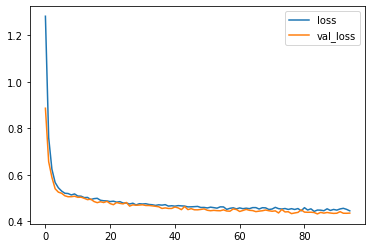

In [219]:
plt.figure(figsize=(20,10))
dfMlpHistory = pd.DataFrame(oMlpModel.history.history)

dfMlpHistory[["loss", "val_loss"]].plot()

In [220]:
aPredictedMlpProbability = oMlpModel.predict(dfTrainX)

aPredictedMlp = np.zeros(aPredictedMlpProbability.shape)
aPredictedMlp[aPredictedMlpProbability >= 0.5] = 1
print(classification_report(dfTrainY, aPredictedMlp, zero_division = 0))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2124
           1       0.79      0.89      0.83      2064

    accuracy                           0.82      4188
   macro avg       0.83      0.83      0.82      4188
weighted avg       0.83      0.82      0.82      4188



### Test

In [221]:
aPredictedMlpProbability = oMlpModel.predict(dfTestX)

aPredictedMlp = np.zeros(aPredictedMlpProbability.shape)
aPredictedMlp[aPredictedMlpProbability >= 0.5] = 1
print(classification_report(dfTestY, aPredictedMlp, zero_division = 0))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       748
           1       0.34      0.83      0.49       131

    accuracy                           0.74       879
   macro avg       0.65      0.78      0.66       879
weighted avg       0.87      0.74      0.77       879



## Long-Short Term Memory

### Train

In [222]:
oLstmModel = tf.keras.Sequential()

oLstmModel.add(LSTM(100, activation = "relu", kernel_regularizer=oKernelRegulizer))
oLstmModel.add(Dropout(0.5))
oLstmModel.add(Dense(1, activation='sigmoid'))

oLstmModel.compile(optimizer=oOptimizer, loss='binary_crossentropy', metrics=['accuracy'])

oLstmModel.fit(tf.expand_dims(dfTrainX, 1), 
                dfTrainY, 
                epochs=c_i_EPOCH_SIZE, 
                batch_size=c_i_BATCH_SIZE, 
                verbose=1, 
                validation_data= (tf.expand_dims(dfValidationX, 1), dfValidationY),
                callbacks=[oEarlyStop]
             )

Epoch 1/1000
262/262 [==============================] - 4s 10ms/step - loss: 0.6059 - accuracy: 0.7089 - val_loss: 0.5663 - val_accuracy: 0.7216
Epoch 2/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.5571 - accuracy: 0.7280 - val_loss: 0.5461 - val_accuracy: 0.7389
Epoch 3/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.5446 - accuracy: 0.7352 - val_loss: 0.5428 - val_accuracy: 0.7316
Epoch 4/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.5336 - accuracy: 0.7455 - val_loss: 0.5270 - val_accuracy: 0.7489
Epoch 5/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.5269 - accuracy: 0.7512 - val_loss: 0.5160 - val_accuracy: 0.7578
Epoch 6/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.5177 - accuracy: 0.7612 - val_loss: 0.5094 - val_accuracy: 0.7673
Epoch 7/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.5139 - accuracy: 0.7619 - val_loss: 0.5043 - val_ac

262/262 [==============================] - 5s 21ms/step - loss: 0.4328 - accuracy: 0.8073 - val_loss: 0.4332 - val_accuracy: 0.7984
Epoch 57/1000
262/262 [==============================] - 5s 19ms/step - loss: 0.4333 - accuracy: 0.8030 - val_loss: 0.4326 - val_accuracy: 0.7929
Epoch 58/1000
262/262 [==============================] - 4s 15ms/step - loss: 0.4340 - accuracy: 0.7999 - val_loss: 0.4319 - val_accuracy: 0.8001
Epoch 59/1000
262/262 [==============================] - 3s 10ms/step - loss: 0.4350 - accuracy: 0.8016 - val_loss: 0.4409 - val_accuracy: 0.7862
Epoch 60/1000
262/262 [==============================] - 3s 11ms/step - loss: 0.4281 - accuracy: 0.8054 - val_loss: 0.4329 - val_accuracy: 0.7912
Epoch 61/1000
262/262 [==============================] - 3s 13ms/step - loss: 0.4282 - accuracy: 0.8059 - val_loss: 0.4252 - val_accuracy: 0.7918
Epoch 62/1000
262/262 [==============================] - 4s 15ms/step - loss: 0.4313 - accuracy: 0.8054 - val_loss: 0.4304 - val_accuracy:

<Figure size 1440x720 with 0 Axes>

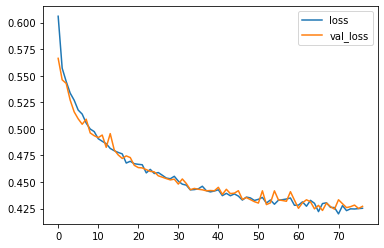

In [223]:
plt.figure(figsize=(20,10))
dfLstmHistory = pd.DataFrame(oLstmModel.history.history)
dfLstmHistory[["loss", "val_loss"]].plot()

In [224]:
aPredictedLstmProbability = oLstmModel.predict(tf.expand_dims(dfTrainX, 1))

aPredictedLstm = np.zeros(aPredictedLstmProbability.shape)
aPredictedLstm[aPredictedLstmProbability >= 0.5] = 1
print(classification_report(dfTrainY, aPredictedLstm, zero_division = 0))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      2124
           1       0.77      0.92      0.84      2064

    accuracy                           0.82      4188
   macro avg       0.84      0.82      0.82      4188
weighted avg       0.84      0.82      0.82      4188



### Test

In [225]:
aPredictedLstmProbability = oLstmModel.predict(tf.expand_dims(dfTestX, 1))

aPredictedLstm = np.zeros(aPredictedLstmProbability.shape)
aPredictedLstm[aPredictedLstmProbability >= 0.5] = 1
print(classification_report(dfTestY, aPredictedLstm, zero_division = 0))

              precision    recall  f1-score   support

           0       0.96      0.69      0.81       748
           1       0.32      0.84      0.47       131

    accuracy                           0.72       879
   macro avg       0.64      0.77      0.64       879
weighted avg       0.87      0.72      0.76       879



## ROC Curves

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In this context, Multi Layer Perceptron outperforms other models.

Source:

1. https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

1. https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

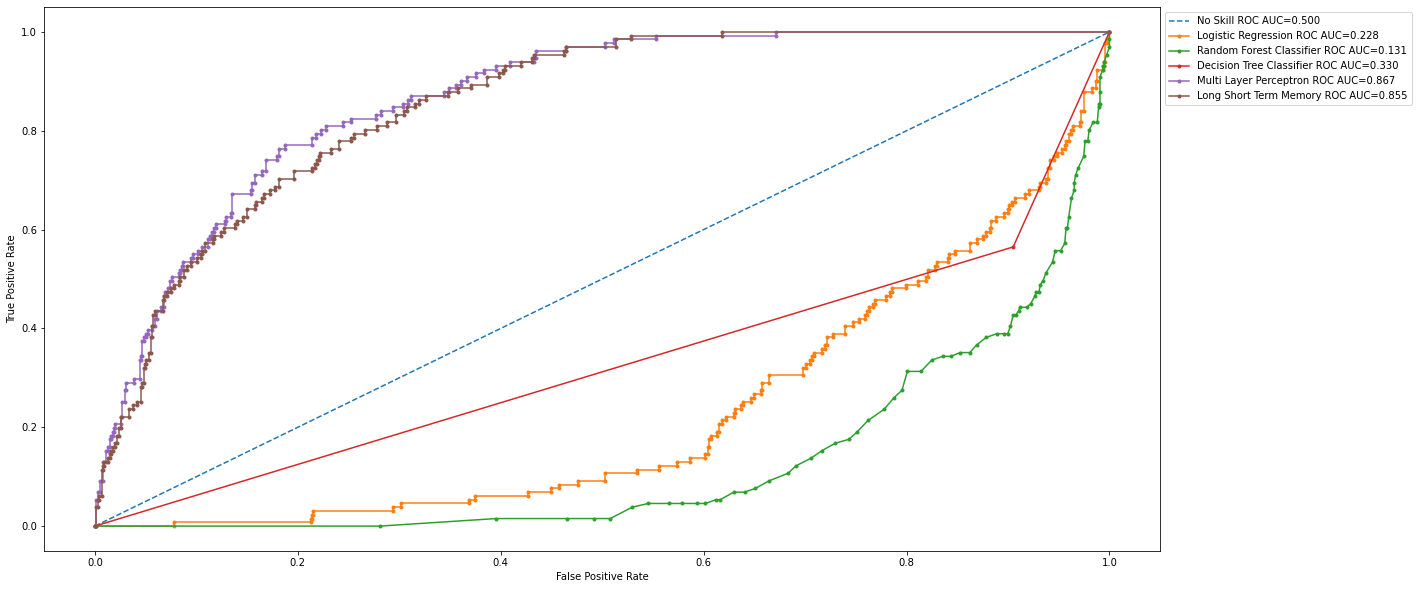

In [226]:
aNoSkillProbability = [0 for _ in range(len(dfTestY))]

fAucNoSkill = metrics.roc_auc_score(dfTestY, aNoSkillProbability)
fAucLogReg = metrics.roc_auc_score(dfTestY, aPredictedLogRegProbability[:,0])
fAucRandForest = metrics.roc_auc_score(dfTestY, aPredictedRandForestProbability[:,0])
fAucDecTree = metrics.roc_auc_score(dfTestY, aPredictedDecTreeProbability[:,0])
fAucMlp = metrics.roc_auc_score(dfTestY, aPredictedMlpProbability[:,0])
fAucLstm = metrics.roc_auc_score(dfTestY, aPredictedLstmProbability[:,0])



aFprNoSkill, aTprNoSkill, _ = metrics.roc_curve(dfTestY, aNoSkillProbability)
aFprLogReg, aTprLogReg, _ = metrics.roc_curve(dfTestY,  aPredictedLogRegProbability[:,0])
aFprRandForest, aTprRandForest, _ = metrics.roc_curve(dfTestY,  aPredictedRandForestProbability[:,0])
aFprDecTree, aTprDecTree, _ = metrics.roc_curve(dfTestY,  aPredictedDecTreeProbability[:,0])
aFprMlp, aTprMlp, _ = metrics.roc_curve(dfTestY,  aPredictedMlpProbability[:,0])
aFprLstm, aTprLstm, _ = metrics.roc_curve(dfTestY,  aPredictedLstmProbability[:,0])

plt.figure(figsize=(20,10))
plt.plot(aFprNoSkill, aTprNoSkill, linestyle='--', label='No Skill ROC AUC=%.3f' % (fAucNoSkill))
plt.plot(aFprLogReg, aTprLogReg, marker='.', label='Logistic Regression ROC AUC=%.3f' % (fAucLogReg))
plt.plot(aFprRandForest, aTprRandForest, marker='.', label='Random Forest Classifier ROC AUC=%.3f' % (fAucRandForest))
plt.plot(aFprDecTree, aTprDecTree, marker='.', label='Decision Tree Classifier ROC AUC=%.3f' % (fAucDecTree))
plt.plot(aFprMlp, aTprMlp, marker='.', label='Multi Layer Perceptron ROC AUC=%.3f' % (fAucMlp))
plt.plot(aFprLstm, aTprLstm, marker='.', label='Long Short Term Memory ROC AUC=%.3f' % (fAucLstm))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

# NOTES

In order to improve the descriptive & predictive models, following steps could be done:

1. Preprocessing
    1. Clustering of some fields (e.g. CUSTOMER_AGE) could be applied.
    2. Request additional data states if a customer is active/has loan during transaction time or not. Current ACTIVE and LOAN fields don't imply if it is during transaction date or not.
    3. Principal component analysis can be used to focus significant impacts of features.
2. Descriptive Analysis
    1. I already applied statistical methods like ANOVA to detect homogeneity between features. However, there were no significant results from statistical perspective due to normality assumption of data and residuals.  
2. Predictive models
    1. Hyperparameter tuning via
        1. Genetic algorithms
        2. Statistical models (experimental design)
     